In [ ]:
pip install emoji pyLDAvis

In [157]:
import pandas as pd 
import nltk,spacy,re,emoji,pyLDAvis,requests
from  nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from bs4 import BeautifulSoup
from wordcloud import WordCloud,STOPWORDS
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()
df = pd.read_csv('/content/drive/My Drive/Tweets-A.csv')
df.head()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,tweet_id,airline_sentiment,name,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,5.703060e+17,neutral,cairdin,@VirginAmerica What @dhepburn said.,NaN,24/02/15 11:35,NaN,Eastern Time (US & Canada)
1,5.703010e+17,positive,jnardino,@VirginAmerica plus you've added commercials t...,NaN,24/02/15 11:15,NaN,Pacific Time (US & Canada)
2,5.703010e+17,neutral,yvonnalynn,@VirginAmerica I didn't today... Must mean I n...,NaN,24/02/15 11:15,Lets Play,Central Time (US & Canada)
3,5.703010e+17,negative,jnardino,@VirginAmerica it's really aggressive to blast...,NaN,24/02/15 11:15,NaN,Pacific Time (US & Canada)
4,5.703010e+17,negative,jnardino,@VirginAmerica and it's a really big bad thing...,NaN,24/02/15 11:14,NaN,Pacific Time (US & Canada)


In [11]:
#function for treatment of verbs form and apostrophe in text
def decontracted(phrase):
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase


In [189]:
#TweetId is primary key.......Tweet_cord has more than 80% of missing rows so dropped it
df_data = df.copy()
df_data.drop(columns=['tweet_id','tweet_coord'],inplace=True)

#Column ['Text'] pre-processing by converting it to lower case
df_data.text = df_data.text.apply(lambda text:text.lower() if type(text) == str else text)

#HREF Links Removal
df_data.text = df_data.text.apply(lambda text: re.compile(r'https?://\S+|www\.\S+').sub(r'',text))
# df_data.text = df_data.text.apply(lambda text: re.compile(r'http?://\S+|www\.\S+').sub(r'',text))
#HTML Text Removal
df_data.text = df_data.text.apply(lambda text: BeautifulSoup(text,'html.parser').text)

#HashTags Separation And Merging
df_data['hashtags'] = [ [ tag[1: ] for tag in i.split() if tag.startswith('#') ] for i in df_data.text ]

#@Entities Separation And Merging
df_data['tags'] = [ [ ent[1: ] for ent in i.split() if ent.startswith("@") ] for i in df_data.text ]

#Decontraction
df_data.text = df_data.text.apply(lambda x :decontracted(x))

# @Words Removal from text
df_data.text = [ " ".join([ sent for sent in text.split(" ") if sent.startswith("@") == False  ]) for text in df_data.text]

#converting emojis to words.
df_data.text = df_data.text.apply(lambda text : re.sub('_',' ',emoji.demojize(text)))

#Punctuations Removal
df_data.text = df_data.text.str.replace('[^\w\s]','')

#StopWords Removal
df_data.text = [ " ".join(([word for word in word_tokenize(i) if not word in list((stopwords.words('english')))]))  for i in df_data.text ]

#Lemmatization - Aiming to remove inflectional endings and return the base meaning or dictionary meaning of a word also known as lemma
df_data.text = df_data.text.apply(lambda text: lemmatizer.lemmatize(text))

#Tokenization - We'll be using white space tokenizer as other tokenizers separate on condition which doesn't help us portray meaninng of words
df_data['tokenised_text'] = [[word for word in word_tokenize(i)] for i in df_data.text]

#MissingValues in Columns ['user_timezone','tweet_location']
df_data.tweet_location,df_data.user_timezone = [df_data[i].fillna(df_data[i].value_counts().nlargest(n=1).index[0]) for i in ['tweet_location','user_timezone']]

#Recheck for missing values
print("No Missing Data" if (all(df_data.isna().any()==False )) else False)
df_data.head(10)

No Missing Data


,airline_sentiment,name,text,tweet_created,tweet_location,user_timezone,hashtags,tags,tokenised_text
0,neutral,cairdin,said,24/02/15 11:35,"Boston, MA",Eastern Time (US & Canada),[],"[virginamerica, dhepburn]",[said]
1,positive,jnardino,plus added commercials experience tacky,24/02/15 11:15,"Boston, MA",Pacific Time (US & Canada),[],[virginamerica],"[plus, added, commercials, experience, tacky]"
2,neutral,yvonnalynn,today must mean need take another trip,24/02/15 11:15,Lets Play,Central Time (US & Canada),[],[virginamerica],"[today, must, mean, need, take, another, trip]"
3,negative,jnardino,really aggressive blast obnoxious entertainmen...,24/02/15 11:15,"Boston, MA",Pacific Time (US & Canada),[],[virginamerica],"[really, aggressive, blast, obnoxious, enterta..."
4,negative,jnardino,really big bad thing,24/02/15 11:14,"Boston, MA",Pacific Time (US & Canada),[],[virginamerica],"[really, big, bad, thing]"
5,negative,jnardino,seriously would pay 30 flight seats playing re...,24/02/15 11:14,"Boston, MA",Pacific Time (US & Canada),[],[virginamerica],"[seriously, would, pay, 30, flight, seats, pla..."
6,positive,cjmcginnis,yes nearly every time fly vx ear worm wont go ...,24/02/15 11:13,San Francisco CA,Pacific Time (US & Canada),[],[virginamerica],"[yes, nearly, every, time, fly, vx, ear, worm,..."
7,neutral,pilot,really missed prime opportunity men without ha...,24/02/15 11:12,Los Angeles,Pacific Time (US & Canada),[],[virginamerica],"[really, missed, prime, opportunity, men, with..."
8,positive,dhepburn,well notbut,24/02/15 11:11,San Diego,Pacific Time (US & Canada),[],[virginamerica],"[well, notbut]"
9,positive,YupitsTate,amazing arrived hour early good,24/02/15 10:53,Los Angeles,Eastern Time (US & Canada),[],[virginamerica],"[amazing, arrived, hour, early, good]"


/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


Text(0.5, 0, 'entities mentioned')

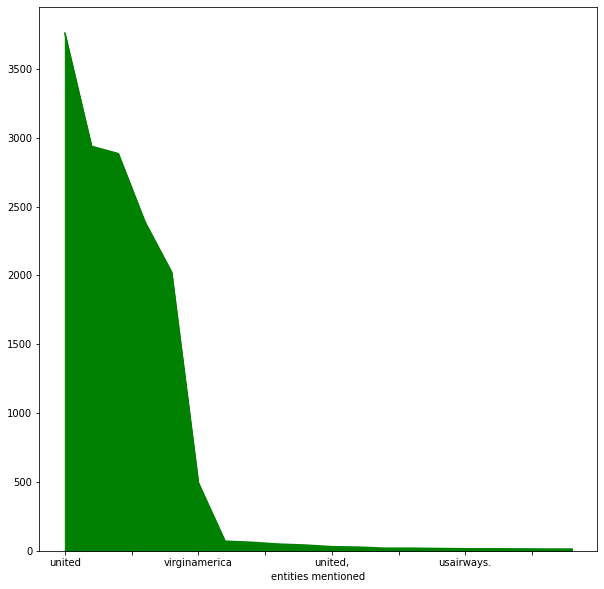

In [149]:
# Converting Array Tags into string and visualising them

split_data = df_data.copy()
split_data,split_data.tags = df_data.iloc[[i for i,j in enumerate(df_data['tags']) for value in j] , :],[value for i in df_data['tags'] for value in i]
# split_data.head(10)
split_data.tags.value_counts()[:20].plot.area(figsize=[10,10],color="g").set_xlabel('entities mentioned')
#Maximum tweets mentioned {united airways},then {virginamerica}

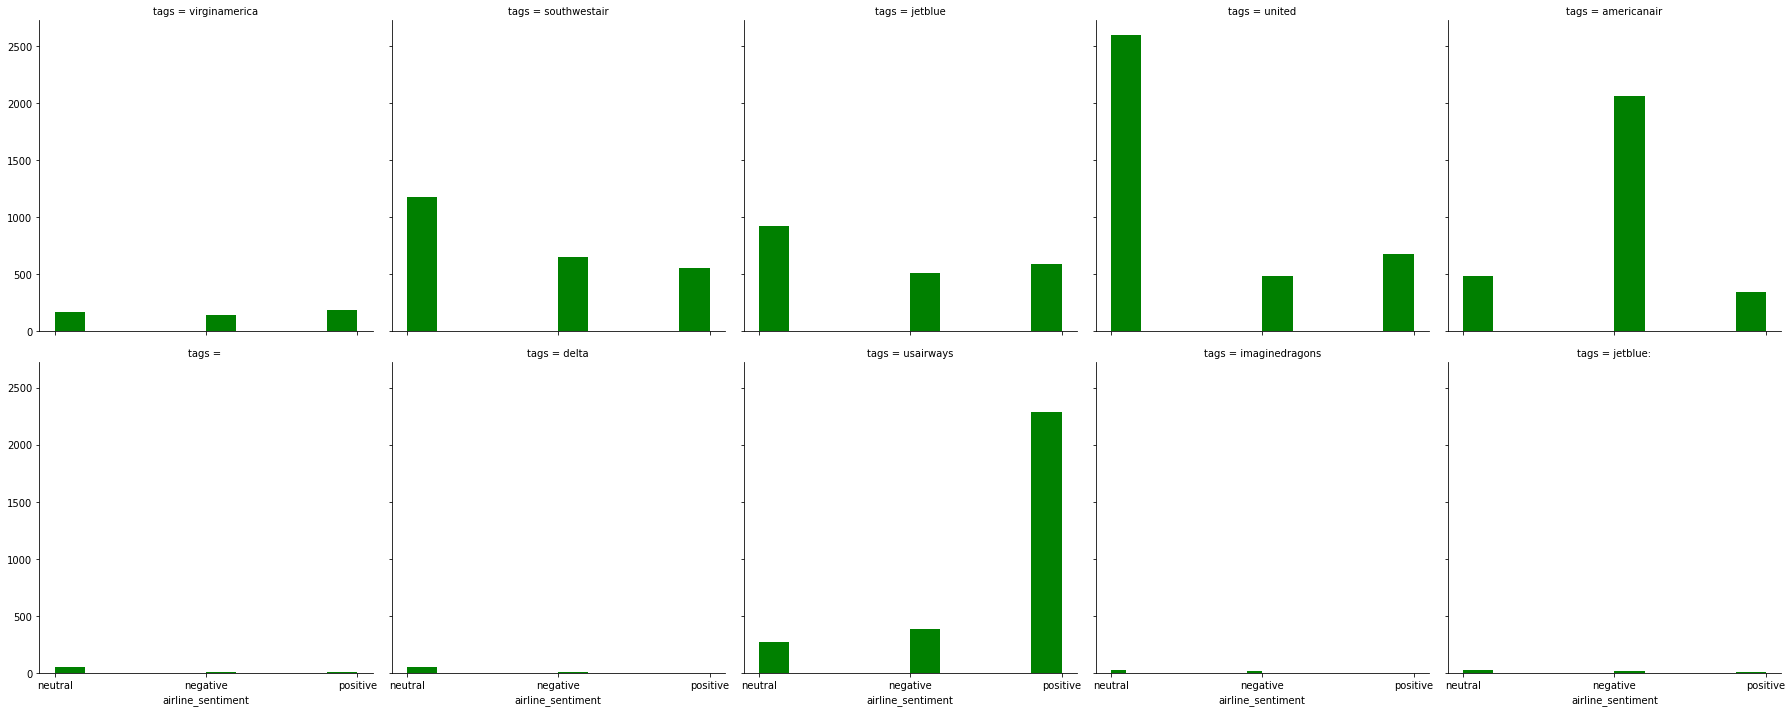

In [155]:
raw_df = split_data[(split_data.tags.isin(split_data.tags.value_counts()[:10].index.to_list()))]
a = sns.FacetGrid(raw_df,col="tags",col_wrap=5, height=5,aspect =1)
a = a.map(plt.hist,'airline_sentiment',color='g')
# virgin america airways have almost equal number of positive negative and neutral
# southwestair have neutral higher means it is ok for airline to continue
# most negative are of american air which shd be a pressing issue
# positive sentiment is maximum for usairways 

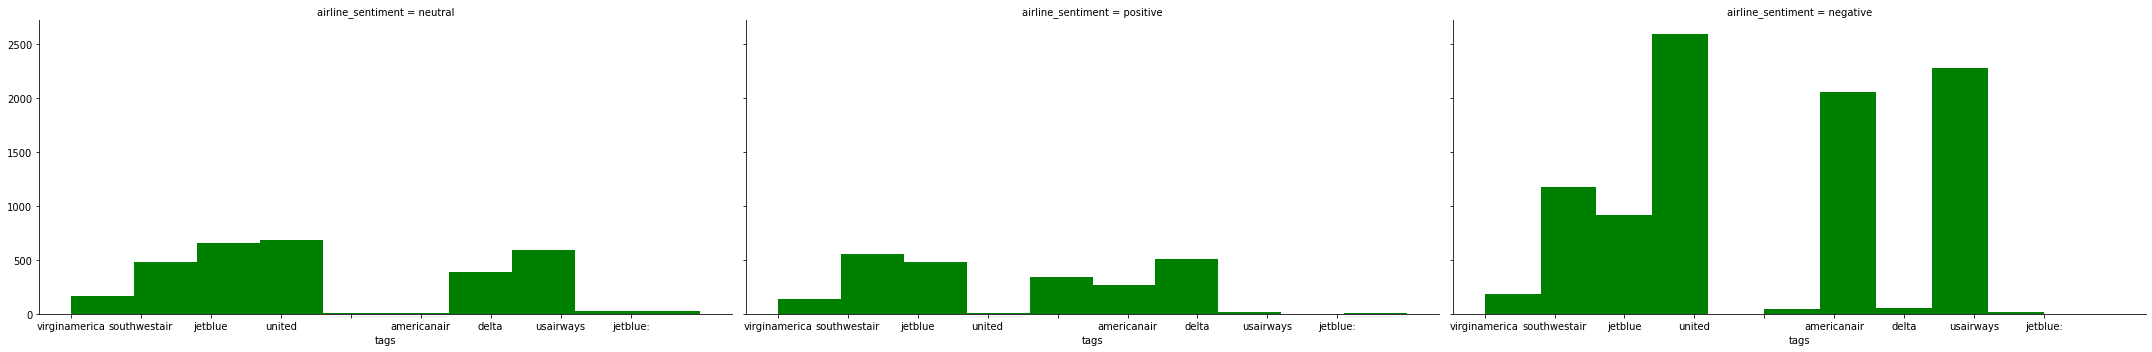

In [160]:
a = sns.FacetGrid(raw_df,col="airline_sentiment",col_wrap=3, height=5,aspect =2)
a = a.map(plt.hist,'tags',color='g')

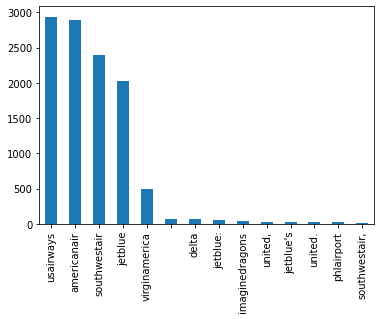

In [87]:
split_data.tags.value_counts()[1:15].plot.bar()

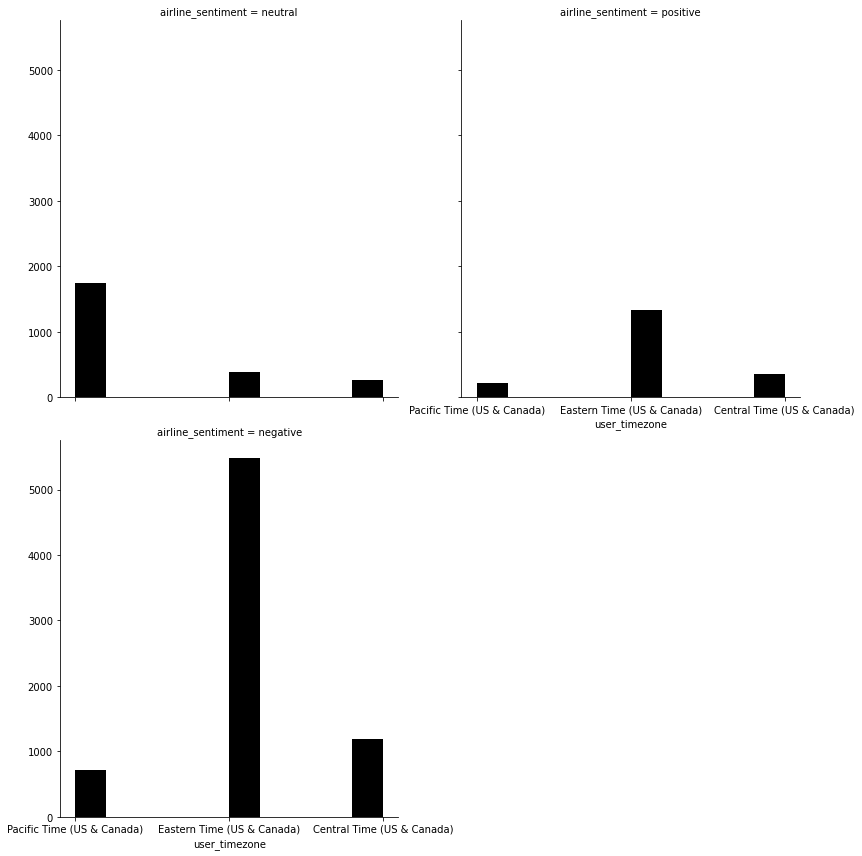

In [179]:
import seaborn as sns
# df_data['user_timezone'].value_counts().plot.bar().set_xlabel('Sentiments_Division')
a=sns.FacetGrid(df_data[df_data['user_timezone'].isin(df_data.user_timezone.value_counts()[:3].index.to_list())],col='airline_sentiment',col_wrap=2,height=6,)
a=a.map(plt.hist,'user_timezone',color='0')
# Top 3 timezones with tweets in comparision to sentiment

Text(0.5, 0, 'Sentiments_Division')

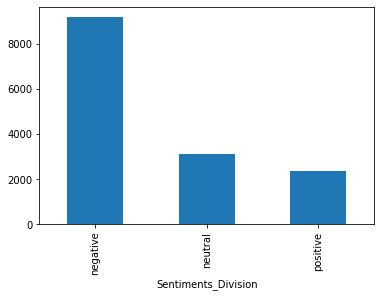

In [180]:
df_data['airline_sentiment'].value_counts().plot.bar().set_xlabel('Sentiments_Division')
# Out of 14500 Tweets it is visible that more than 70% of tweets have negative sentiment
# It can also be a problem which can be more clearly told after topic or entities are separated from text with respect to sentiment

In [ ]:
import gensim
from gensim import models,corpora
dictionary_LDA = gensim.corpora.Dictionary(df_data.tokenised_text)
dictionary_LDA.filter_extremes(no_below=3)
corpus = [dictionary_LDA.doc2bow(list_of_tokens) for list_of_tokens in df_data.tokenised_text]
num_topics = 50

%time lda_model = models.LdaModel(corpus, num_topics=num_topics,id2word=dictionary_LDA,passes=4,alpha=[0.01]*num_topics,eta=[0.01]*len(dictionary_LDA.keys()))

In [182]:
for i,topic in lda_model.show_topics(formatted=True, num_topics=10):
    print(topic)

0.111*"yes" + 0.086*"keep" + 0.068*"yesterday" + 0.061*"6" + 0.054*"look" + 0.050*"making" + 0.044*"today" + 0.038*"instead" + 0.029*"used" + 0.025*"wo"
0.116*"fly" + 0.111*"go" + 0.102*"never" + 0.044*"time" + 0.041*"calls" + 0.034*"would" + 0.033*"every" + 0.033*"helpful" + 0.028*"believe" + 0.026*"disappointed"
0.129*"line" + 0.096*"info" + 0.087*"website" + 0.075*"says" + 0.067*"boarding" + 0.056*"full" + 0.050*"busy" + 0.023*"flight" + 0.022*"people" + 0.022*"land"
0.086*"hotel" + 0.083*"miles" + 0.055*"working" + 0.047*"needs" + 0.042*"away" + 0.042*"option" + 0.041*"upset" + 0.041*"get" + 0.032*"philly" + 0.031*"possible"
0.105*"2" + 0.069*"great" + 0.063*"hours" + 0.060*"tell" + 0.059*"lax" + 0.046*"food" + 0.042*"say" + 0.035*"almost" + 0.033*"12" + 0.030*"without"
0.188*"weather" + 0.107*"crew" + 0.077*"agents" + 0.071*"flight" + 0.063*"reservations" + 0.049*"miss" + 0.033*"connecting" + 0.026*"vegas" + 0.025*"moved" + 0.020*"southwest"
0.109*"let" + 0.080*"know" + 0.069*"ton

In [185]:
lda_model[corpus[1]]

[(1, 0.22444445), (14, 0.22444445), (26, 0.22281027), (41, 0.22607864)]

In [183]:
import pyLDAvis
import pyLDAvis.gensim
vis = pyLDAvis.gensim.prepare(topic_model=lda_model, corpus=corpus, dictionary=dictionary_LDA)
pyLDAvis.enable_notebook()
pyLDAvis.display(vis)

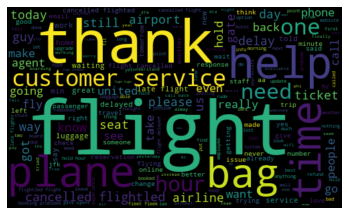

In [ ]:
# WordCloudVisualisation
allWords = ' '.join([twts for twts in df_data.text])
wordCloud = WordCloud(width=500, height=300, random_state=21, max_font_size=110).generate(allWords)
plt.imshow(wordCloud, interpolation="bilinear")
plt.axis('off')
plt.show()

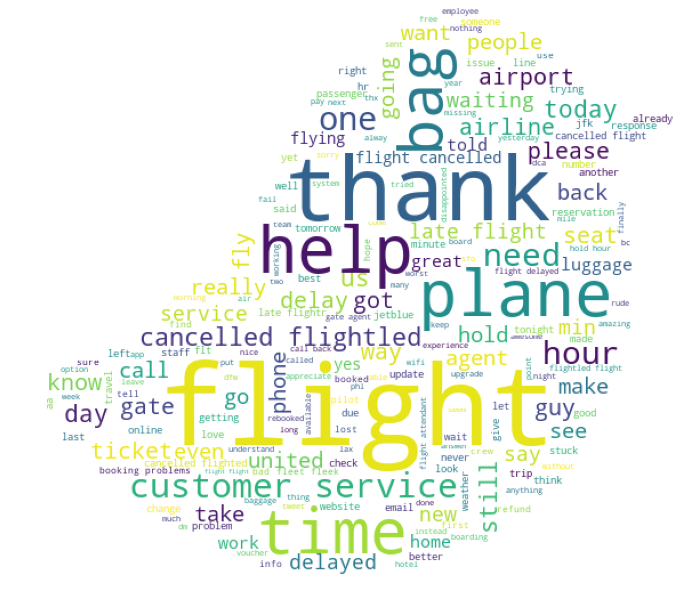

In [186]:
mask = np.array(Image.open(requests.get('http://www.clker.com/cliparts/F/O/V/V/E/w/tweeter-bird-hi.png', stream=True).raw))
def generate_wordcloud(words, mask):
    word_cloud = WordCloud(width = 612, height = 612, background_color='white', stopwords=STOPWORDS, mask=mask).generate(words)
    plt.figure(figsize=(10,8),facecolor = 'white', edgecolor='black')
    print()
    plt.imshow(word_cloud),plt.axis("off")
    plt.tight_layout(pad=0)
    plt.show()

# Most Accuring Words In Whole Text
generate_wordcloud(' '.join([twts for twts in df_data.text]), mask)

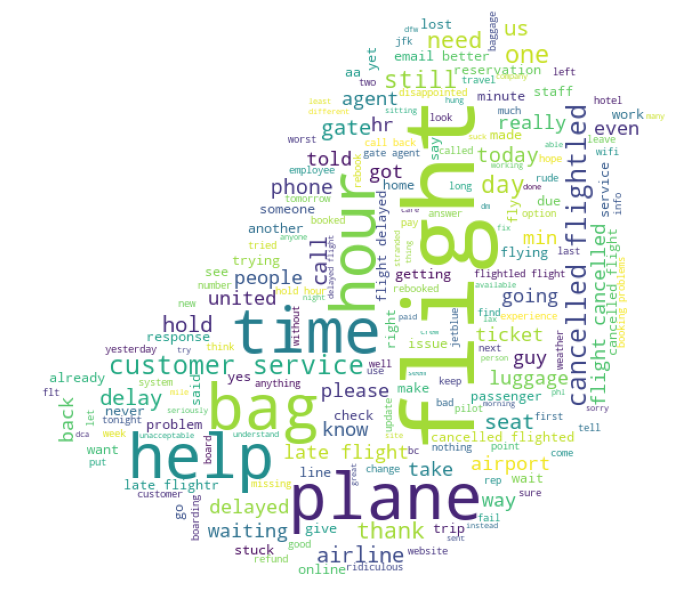

In [187]:
# Most Frequent Words In Negative Labeled Sentiment
generate_wordcloud(' '.join([twts for twts in df_data.loc[df_data["airline_sentiment"] == "negative", 'text']]), mask)

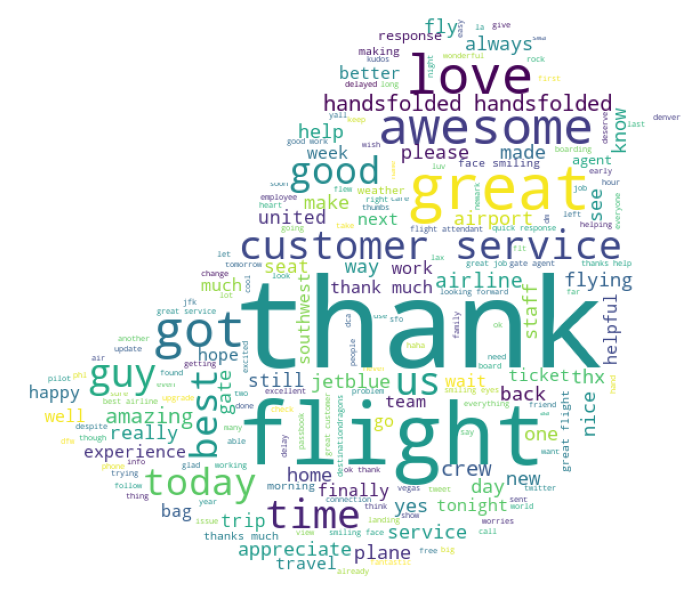

In [188]:
# Most Frequent Word In Positive Labeled Sentiment
generate_wordcloud(' '.join([twts for twts in df_data.loc[df_data["airline_sentiment"] == "positive", 'text']]), mask)


In [ ]:
from time import time
df_data.to_csv(str(int(time()))+'_Update1.csv')